## I. BCS single-band Superconductivity
As per BCS theory, the mean-field Hamiltonian can be rewritten using the Numbu spinor as 
$$ H = \sum_{\mathbf{k}} \psi^{\dagger}_{ \mathbf{k}} (\vec{h}_{ \mathbf{k}} \cdot \vec{\tau}_{}) \psi_{ \mathbf{k}} - V A^{*} A
 = \sum_{\mathbf{k}} \psi^{\dagger}_{ \mathbf{k}} (\vec{h}_{ \mathbf{k}} \cdot \vec{\tau}_{}) \psi_{ \mathbf{k}} + \frac{V}{g_0} |\Delta|^2, $$
where $$A = \sum_{\mathbf{k}}c_{-\mathbf{k},\downarrow} c_{\mathbf{k}, \uparrow}, \quad \Delta = - \frac{g_0}{V} <A>$$
and $\vec{h} = (\mathrm{Re}(\Delta), -\mathrm{Im}(\Delta), \varepsilon_{\mathbf{k}})$ is a Zeeman field in the isospin space.

As the first term in the Hamiltonian is quadratic in the fermionic field operator, the saddle-point partition function is 
$$S = \int_0^\beta \mathrm{d}\tau H,$$
$$Z = \int \mathcal{D}[\Delta, \Delta^*, \psi, \psi^\dagger] \exp(-S)= \prod_{i \omega_n, \mathbf{k}} \mathrm{det}(- i \omega_n + \vec{h}_{ \mathbf{k}} \cdot \vec{\tau}) \exp{[- \frac{V \beta}{g_0} |\Delta|^2]},$$
where the first term is exactly the 2*2 Nambu-Gorkov Green's function $\mathcal{G}^{-1} = -(\partial_{\tau} - \mathcal{H})$
$$\mathcal{G}(\mathbf{k}, i \omega_n)^{-1} = 

- 
\left[\begin{array}{ccc}
<T c_{\mathbf{k}, \uparrow}(\tau) c_{\mathbf{k}, \uparrow}^\dagger(0)> & T c_{\mathbf{k}, \uparrow}(\tau) c_{\mathbf{-k}, \downarrow}(0)>\\
<T c_{\mathbf{-k}, \downarrow}^\dagger(\tau) c_{\mathbf{k}, \uparrow}^\dagger(0)>& <T c_{\mathbf{-k}, \downarrow}^\dagger(\tau) c_{-\mathbf{k}, \downarrow}(0)>
\end{array}\right]

$$
This gives the free energy as 
$$
F = T \ln{\mathrm{det}(-G^{-1})} + \frac{V}{g_0} |\Delta|^2= - T \sum_{n, \mathrm{k}} \ln[\omega_n^2 + \epsilon_k^2 + |\Delta(T)|^2]e^{i \omega_n (i 0^{+})} + \frac{V}{g_0} |\Delta|^2
$$

Convergence of the first term is numerically hard, as a constant infinity needs to be renormalised away to force convergence. The first term can be analytically evaluated using contour integration to give (integrating over a constant density of states at the Fermi surface)

$$ 
f = -2T N(0)  \int_0^\infty \mathrm{d}\varepsilon [\ln(2 \cosh(\beta E_{k}(\Delta, \varepsilon) / 2))] + \frac{V}{g_0} |\Delta|^2, \quad E_k = \sqrt{\varepsilon_k^2 + \Delta^2}$$




### 1. Summing over Matsubara frequencies analytically

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, root
from scipy.integrate import quad, simpson
from scipy.stats import linregress
from mpmath import zeta, gamma
import mpmath as mp
beta = lambda T: 1/T 
Delta0 = 1


In [68]:
# calculate the gap at different temperatures
def E(eps, Delta):
    return np.sqrt(eps**2 + Delta**2)
def GapInt(eps, Delta, T):
    return np.tanh(beta(T)* E(eps, Delta) / 2) / E(eps, Delta) - 1/E(eps, Delta0)
def root_function(Delta, T):
    integral, error = quad(GapInt, 0, np.inf, args=(Delta, T))
    return integral
def solveGap(T):
    # Initial guess for Delta
    Delta_guess = 1.0
    
    # Find the root of the function using scipy.optimize.root
    sol = root(root_function, Delta_guess, args=(T,))
    
    if sol.success:
        Delta_root = sol.x[0]
        # print(f"Root Delta at T={T}: {Delta_root}")
    else:
        Delta_root = 0
        # print(f"Root finding did not converge for T={T}.")
    
    # Check the integral at the found root Delta
    integral_at_root, error = quad(GapInt, 0, np.inf, args=(Delta_root, T))
    # print(f"Integral at root Delta for T={T}: {integral_at_root}")

    return Delta_root
omega_D = 5 # cutoff energy
Tc = 0.5665
T_arr = np.linspace(0,Tc+0.2,100)# Example usage
Delta_arr = np.zeros(np.shape(T_arr))
for i in range(len(T_arr)):
    Delta_arr[i] = solveGap(T_arr[i])

C:\Users\tcsxx\AppData\Local\Temp\ipykernel_23880\695360525.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  beta = lambda T: 1/T


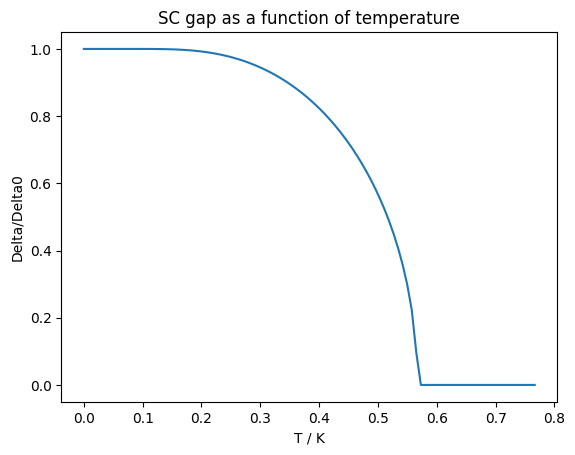

In [4]:
plt.plot(T_arr, Delta_arr) # plot gap against T
plt.xlabel('T / K')
plt.ylabel('Delta/Delta0')
plt.title('SC gap as a function of temperature')
plt.show()

C:\Users\tcsxx\AppData\Local\Temp\ipykernel_23880\1989104635.py:3: RuntimeWarning: invalid value encountered in sqrt
  return np.where(E <= np.abs(Delta), 0, E / np.sqrt(E**2 - Delta**2))


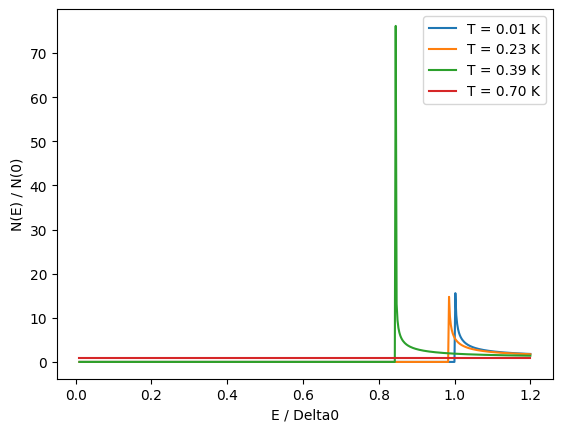

In [5]:
def DoS(E, Delta):
    # expect E array, Delta is a scalar.
    return np.where(E <= np.abs(Delta), 0, E / np.sqrt(E**2 - Delta**2))

indexlist = [1, 30, 50, 90]
E_arr = np.linspace(0.01, 1.2, 500)

for i in indexlist:
    T_eval = T_arr[i]
    plt.plot(E_arr, DoS(E_arr, Delta_arr[i]), label=f"T = {T_eval:.2f} K")

plt.xlabel('E / Delta0')
plt.ylabel('N(E) / N(0)')
plt.legend(loc='best')
plt.show()

In [6]:
def F(T):
    # find free energy at a given temperature by performing the integral (14.145) from Coleman
    Delta = solveGap(T)
    integrand_g0 = lambda eps,Delta,T: np.tanh(beta(T) * E(eps,Delta) / 2) / (2 * E(eps, Delta))
    g0 = 1/(quad(integrand_g0,0,omega_D, args = (Delta, T))[0])# Eq.(14.139) from Coleman, BCS gap equation II

    integrand = lambda eps, Delta, T:  np.log(2 * np.cosh(beta(T) * E(eps,Delta) / 2)) # integrand for the free energy integral
    free_energy = -2*T*quad(integrand, 0, omega_D, args = (Delta, T))[0] + Delta**2 / g0# integrate from 0 to omega_D, assuming a constant density of states at the Fermi energy
    return free_energy
def numerical_derivative(y,x):
    """
    Compute the derivative of y with respect to x using finite difference method.
    
    Parameters:
    - x: array-like, shape (n,)
    - y: array-like, shape (n,)
    
    Returns:
    - dy_dx: array-like, shape (n,), the derivative dy/dx
    """
    x = np.asarray(x)
    y = np.asarray(y)
    dy_dx = np.zeros_like(y)

    # Central difference for interior points
    dy_dx[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])

    # Forward/backward difference for boundary points
    dy_dx[0] = (y[1] - y[0]) / (x[1] - x[0])
    dy_dx[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])

    return dy_dx
def heat_capacity_F(F_arr, T_arr):
    # calculate the heat capacity given free energy array and temperature array
    C = - T_arr *  numerical_derivative(numerical_derivative(F_arr , T_arr), T_arr)
    return C 
def entropy_F(F_arr, T_arr):
    S = - numerical_derivative(F_arr, T_arr)
    return S

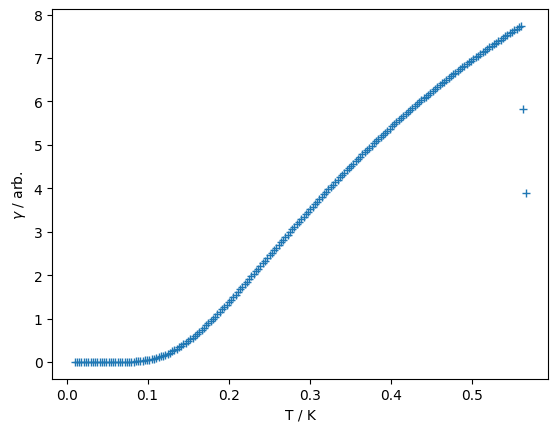

In [7]:
omega_D = 5 # cutoff energy
Tc = 0.5665
T_arr = np.linspace(0.01,Tc,200)# Example usage

F_arr = np.zeros(np.shape(T_arr))
for i in range(np.size(T_arr)):
    F_arr[i] = F(T_arr[i])
    
C_arr = heat_capacity_F(F_arr, T_arr)
S_arr = entropy_F(F_arr, T_arr)
plt.plot(T_arr, C_arr / T_arr, '+')
plt.xlabel('T / K')
plt.ylabel(r'$\gamma$ / arb.')
plt.show()

In [8]:
# Split the data into normal and superconducting phases
normal_phase_mask = T_arr > Tc
superconducting_phase_mask = T_arr <= Tc

T_normal = T_arr[normal_phase_mask]
S_normal = S_arr[normal_phase_mask]

# Perform linear regression on the normal phase data using scipy
slope, intercept, r_value, p_value, std_err = linregress(T_normal, S_normal)

# Print the fitted slope, intercept, and standard error
print(f"Slope: {slope:.4f} ± {std_err:.4f}")
print(f"Intercept: {intercept:.4f}")

# Extrapolate the values down to T = 0
T_extrapolate = np.linspace(0, Tc, 100)
S_extrapolate = slope * T_extrapolate + intercept

# Plot the original data
plt.plot(T_arr, S_arr, label='Original Data', color='blue')

# Plot the extrapolated part
plt.plot(T_extrapolate, S_extrapolate, '--', label='Extrapolated (Normal Phase)', color='red')

# Plot styling
plt.ylabel('Entropy / arb.')
plt.xlabel('T / K')
plt.legend()
plt.show()

ValueError: Inputs must not be empty.

#### Discussion
Here, we've recovered the exponential heat capacity for a single-band s-wave superconductor. However, it seems like the first term (log(det(G))) only contributes to a near constant to the free energy, and the gapped behaviour in C solely comes from the second term. Furthermore, the entropy is continuous at the SC transition and traces back to zero at zero temperature. 

The Matsubara sum for F gives a renormalisable infinity, making it hard to implement numerically. Furthermore, it should be noted that differentiation with respect to T doesn't resolve the convergence issue with respect to n, hence renormalisation must be chosen properly. 

Below I implemented the sum with a complex phase exp(i omega_n 0^+). The computation shows that doing this limit doesn't help the Matsubara series converge. Or I need a way to genuinly take n->oo before z->0+. Hence, there is not universal way of enforcing numerical convergence when doing the Matsubara sum. 

$$
k_B T \sum_n F(i \omega_n) = \int_{C^{\prime}} \frac{dz}{2\pi i} F(z) f(z)
$$
where $F(i \omega_n) = \ln(\omega_n^2 + \Delta^2 + \varepsilon_k^2) e^{i \omega_n0+}$



### 2. Numerical summation over Matsubara frequencies

In [9]:

def omegaMatsu(n,temperature):
    omega = (2*n+1)*np.pi*temperature
    return omega
def sumMatsu_F(eps, T, Delta): # perform the Matsubara sum at eps for free energy
    maxN = omega_cutoff / (2 * np.pi * T)
    omega_Matsu_positive = omegaMatsu(np.arange(maxN), T)
    summed = np.sum(np.log((omega_Matsu_positive**2 + eps**2 + Delta**2))) # Matsubara sum at a given energy eps, but the sum diverges??
    return 2 * summed
def sumMatsu_g0(eps, T, Delta): # perform the Matsubara sum at eps for g0
    maxN = omega_cutoff / (2 * np.pi * T)
    omega_Matsu_positive = omegaMatsu(np.arange(maxN), T)
    summed = np.sum(1/ (omega_Matsu_positive**2 + eps**2 + Delta**2)) # Matsubara sum at a given energy eps, but the sum diverges??
    return 2 * summed
def g0_Matsu(T, Delta): # return the coupling constant from the Matsubara sum
    integrand = lambda eps, Delta, T: sumMatsu_g0(eps, T, Delta)
    g0_reciprocal = T * quad(integrand, 0, omega_D, args = (T, Delta))[0]
    return 1/g0_reciprocal
def F_Matsu(T): # calculate the free energy from Matsubara sum
    Delta = solveGap(T)
    integral = -T * quad(sumMatsu_F, 0, omega_D, args = (T, Delta))[0]
    F = integral + Delta**2 / g0_Matsu(T, Delta)
    return F


Test convergence of three different regularisation schemes
1. $$ \int_0^{\omega_D} \mathrm{d}\varepsilon\lim_{N \rightarrow \infty}\sum_{n = -N}^{N} \ln[\omega_n^2 + \Delta(T)^2 + \varepsilon^2]$$
2. $$ 2 \int_0^{\omega_D} \mathrm{d}\varepsilon \ln(2 \cosh(\beta \sqrt{\Delta^2 + \varepsilon^2}/2))$$
3. $$ 2 \int_0^{\omega_D} \mathrm{d}\varepsilon \ln(a) (1 - 2 \mathcal{R}(z/a)) - \ln(|\Gamma(z/a)|^2) + \ln(2 \pi) $$
where $z = \pi T - i E_k(\varepsilon, \Delta)$ and $a = 2 \pi T$

The two regularisation methods have been tested to be identical, but they show drastically different behaviours to the original sum truncated at a large yet finite N. However, the regularised sum gives sensible free energy.

In [82]:
# first calculate the series
def direct_partialsum(eps, Delta, T, maxN): # Routine 1. Direct summation of the original series
    omega_Matsu_positive = omegaMatsu(np.arange(maxN), T)
    summed = np.sum(np.log((omega_Matsu_positive**2 + eps**2 + Delta**2))) 
    return summed*2

def contour_integral(eps,Delta,T): # Routine 2. An analytical result from contour integration
    return 2 * np.log(2 * np.cosh(beta(T)*E(eps,Delta)/2))

def zeta_regularised_sum(eps, Delta, T):
    """Routine 3. Regularise the sum using zeta function derivative via finite difference"""
    # Multiply by 2 to account for positive and negative frequencies
    a = 2*np.pi*T
    Ek = E(eps,Delta)
    z = np.pi*T - Ek*1j
    summed = np.log(a)*(1 - 2 * np.real(z)/a) - mp.log(np.abs(gamma(z/a))**2) + np.log(2*np.pi)
    return float(2* summed)

In [84]:
# solve for gaps at different temperatures up to Tc
T_arr = np.linspace(0.01,Tc,200)
Delta_arr = np.zeros(len(T_arr))
for i in range(len(T_arr)):
    Delta_arr[i] = solveGap(T_arr[i])

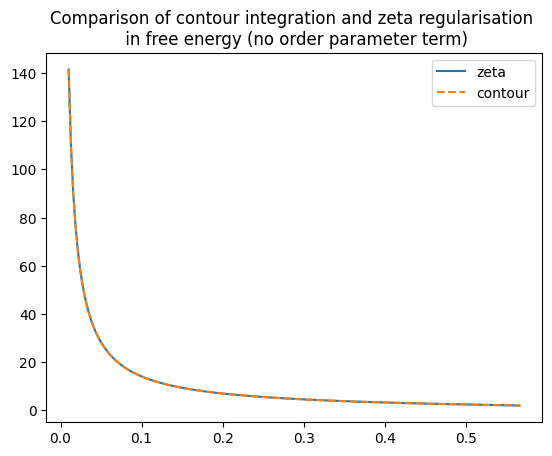

In [91]:
# calculate the sum from method 1
direct_arr = np.zeros(len(T_arr))
zeta_arr = np.zeros(len(T_arr))
contour_arr = np.zeros(len(T_arr))
maxN = 100000
eps = 1
for i in range(len(T_arr)):
    T = T_arr[i]
    Delta = Delta_arr[i]
    direct_arr[i] = direct_partialsum(eps,Delta,T,maxN)
    zeta_arr[i] = zeta_regularised_sum(eps, Delta, T)
    contour_arr[i] = contour_integral(eps,Delta,T)
# plt.plot(T_arr, direct_arr - direct_arr[0])
plt.plot(T_arr, zeta_arr,label = 'zeta')
plt.plot(T_arr, contour_arr,'--',label = 'contour')
plt.title('Comparison of contour integration and zeta regularisation \n in free energy (no order parameter term)')
plt.legend(loc = 'best')
plt.show()

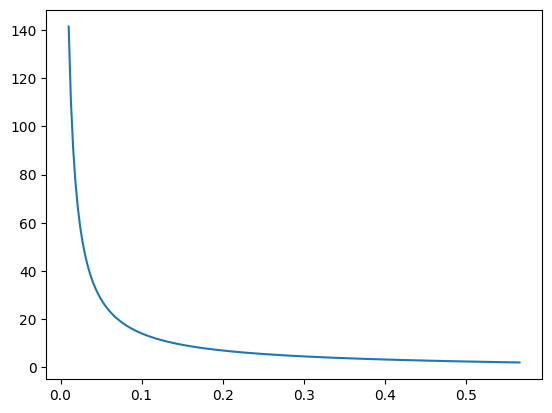

In [47]:
plt.plot(T_arr,contour_integral(1,Delta_arr,T_arr))
plt.show()

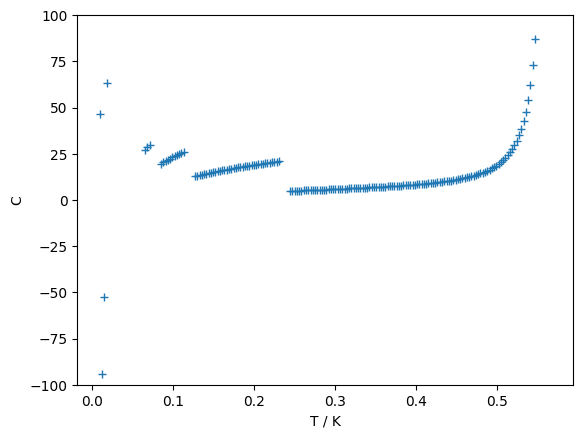

In [29]:
omega_cutoff = 0.3 * omega_D
omega_D = 5 # cutoff energy
Tc = 0.5665
T_arr = np.linspace(0.01,Tc,200)# Example usage

F_arr_Matsu = np.zeros(np.shape(T_arr))
for i in range(np.size(T_arr)):
    F_arr_Matsu[i] = F_Matsu(T_arr[i])
    
C_arr_Matsu = heat_capacity_F(F_arr_Matsu, T_arr)
plt.plot(T_arr, C_arr_Matsu, '+')
plt.xlabel('T / K')
plt.ylabel('C')
plt.ylim(-100,100)
plt.show()

In [10]:
# test convergence of the Matsubara sum sum_n ln(omega^2 + E^2) e^(i omega 0+) -> 2T * ln (2 cosh(beta E_k) / 2)
T = 0.1
Ek = 0.3
omega_cutoff = 15000 * omega_D
maxN = omega_cutoff / (2 * np.pi * T)
omega_Matsu_positive = omegaMatsu(np.arange(maxN), T)
series = np.log(omega_Matsu_positive**2 + Ek**2)
result = []
for delta in np.logspace(-8,0,50):
    result.append(np.sum(series * np.exp(1j * delta * omega_Matsu_positive)))


c:\Users\tcsxx\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tcsxx\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


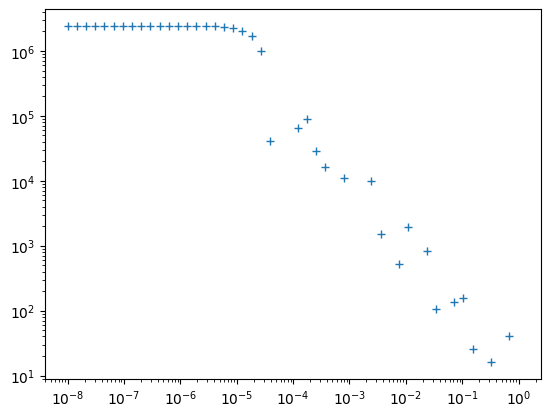

In [11]:
plt.loglog(np.logspace(-8,0,50), result,'+')
plt.show()

## II. Clean $s^{\pm}$ superconductor
In a two-band superconductor, the Hamiltonian can be recast into
$$ H = \sum_{\alpha, \mathbf{k}} \psi^{\dagger}_{\alpha, \mathbf{k}} (\vec{h}_{\alpha, \mathbf{k}} \cdot \vec{\tau}_{\alpha}) \psi_{\alpha, \mathbf{k}} - \sum_{\alpha, \beta} V_{\alpha \beta} A^{*}_\alpha A_\beta, $$
where $\alpha$ is the band index, $\vec{\tau}$ is the Pauli tensor in isospin space, $\psi_{\alpha, \mathbf{k}} = (c_{\mathbf{k}, \uparrow, \alpha}, c^\dagger_{\mathbf{-k}, \downarrow, \alpha})^{\mathrm{T}}$ is the Numbu spinor, $A_\alpha = \sum_{\mathbf{k}} <c_{\mathbf{k}, \uparrow, \alpha} c_{\mathbf{-k}, \downarrow, \alpha}>$ contributes to the order parameter, $\Delta_\alpha = \sum_{\beta} V_{\alpha \beta} A_\beta$ is the order parameter, and 
$\vec{h}_\alpha = (\mathrm{Re}(\Delta), -\mathrm{Im}(\Delta), \varepsilon_{\mathbf{k}, \alpha})$

The first term is a simple sum over the one-band free energy. After rewriting the second term in terms of the order parameter 
$$ \sum_{\alpha, \beta} V_{\alpha \beta} A^{*}_\alpha A_\beta = \frac{1}{\mathrm{det}(V)} 
[V_{11} |\Delta_2|^2 + V_{22} |\Delta_1|^2 - 2 V_{12} \mathrm{Re}(\Delta^*_1 \Delta_2 )], $$
the free energy can be recast using the one-band free-energy (per unit volume)

$$ f = -2T \sum_{\alpha}(N_\alpha(0) \int_0^\infty \mathrm{d}\varepsilon [\ln(2 \cosh(\beta E_{k}(\Delta_\alpha, \varepsilon) / 2))]) - \sum_{\alpha, \beta} V_{\alpha \beta} A^{*}_\alpha A_\beta$$

In [12]:
from gapeqn_library import *
from const import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, root
from scipy.integrate import quad, simpson
beta = lambda T: 1/T 

Delta at T=0:  [ 0.65702129 -1.16405568]


In [13]:
def E(eps, Delta):
    return np.sqrt(eps**2 + Delta**2)

def F_intra_band(T_arr, Delta_arr):
    # vectorized
    # find free energy at a given temperature by performing the integral (14.145) from Coleman
    if len(np.shape(Delta_arr)) > 1:
        print('only array of dimension 1 is accepted as Delta')
        return None
    elif np.size(T_arr) != np.size(Delta_arr):
        print(f'Shape mismatch between T_arr {np.shape(T_arr)} and Delta_arr {np.shape(Delta_arr)}')
        return None
    free_energy_arr = np.zeros(np.shape(Delta_arr))
    for i in range(np.size(Delta_arr)):
        T = T_arr[i]
        Delta = Delta_arr[i]
        integrand = lambda eps, Delta, T:  np.log(2 * np.cosh(beta(T) * E(eps,Delta) / 2)) # integrand for the free energy integral
        free_energy = -2*T*quad(integrand, 0, Omega_c, args = (Delta, T))[0]# integrate from 0 to omega_D, assuming a constant density of states at the Fermi energy
        free_energy_arr[i] = free_energy
    return free_energy_arr


def numerical_derivative(y,x):
    """
    Compute the derivative of y with respect to x using finite difference method.
    
    Parameters:
    - x: array-like, shape (n,)
    - y: array-like, shape (n,)
    
    Returns:
    - dy_dx: array-like, shape (n,), the derivative dy/dx
    """
    x = np.asarray(x)
    y = np.asarray(y)
    dy_dx = np.zeros_like(y)

    # Central difference for interior points
    dy_dx[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])

    # Forward/backward difference for boundary points
    dy_dx[0] = (y[1] - y[0]) / (x[1] - x[0])
    dy_dx[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])

    return dy_dx

def heat_capacity_F(F_arr, T_arr):
    # calculate the heat capacity given free energy array and temperature array
    C = - T_arr *  numerical_derivative(numerical_derivative(F_arr , T_arr), T_arr)
    return C 

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_20504\1235947460.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$')
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_20504\1235947460.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.title('SC Order Parameter $\Delta$ against temperature \n $T$ in a clean two-band superconductor')
c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Python Scripts\two-band-superconductor\gapeqn_library.py:96: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Delta.append(fsolve(lambda D: Eqn(D,t[-1]),Delta[-1],xtol=1e-13))


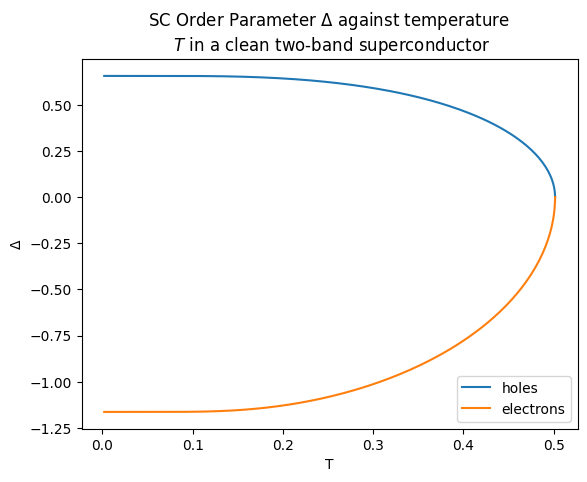

In [14]:
# determine the order parameter
T = 0.6
out = Delta(T)
plt.plot(out[0], out[1][:,0], label = 'holes')
plt.plot(out[0], out[1][:,1], label = 'electrons')
plt.ylabel('$\Delta$')
plt.xlabel('T')
plt.title('SC Order Parameter $\Delta$ against temperature \n $T$ in a clean two-band superconductor')
plt.legend(loc = 'best')
plt.show()

In [15]:
def F_two_band(T, Delta_h, Delta_e):
    # can take in vector input (1D arrays of the same shape)
    detV = Vee * Vhh - Vhe**2 
    F_OP = 1/detV * (Vhh * np.abs(Delta_e)**2 + Vee * np.abs(Delta_h)**2 - 2 * Vhe * np.real(np.conjugate(Delta_e) * Delta_h))# contribution to the mean-field free energy from the order parameters (no signs included yet) 
    F_total = F_intra_band(T, Delta_h) * Nh + F_intra_band(T, Delta_e) * Ne - F_OP 
    return F_total

<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_20504\3363381664.py:9: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel('Sommerfeld Coefficient $\gamma$')
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_20504\1605089431.py:17: RuntimeWarning: overflow encountered in cosh
  integrand = lambda eps, Delta, T:  np.log(2 * np.cosh(beta(T) * E(eps,Delta) / 2)) # integrand for the free energy integral
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_20504\1605089431.py:17: RuntimeWarning: overflow encountered in scalar multiply
  integrand = lambda eps, Delta, T:  np.log(2 * np.cosh(beta(T) * E(eps,Delta) / 2)) # integrand for the free energy integral
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_20504\1605089431.py:39: RuntimeWarning: invalid value encountered in subtract
  dy_dx[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_20504\1605089431.py:42: RuntimeWar

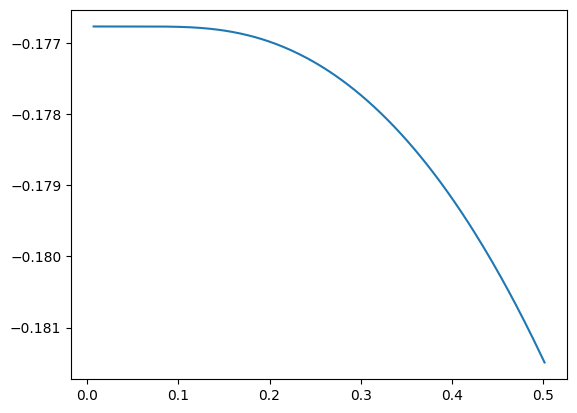

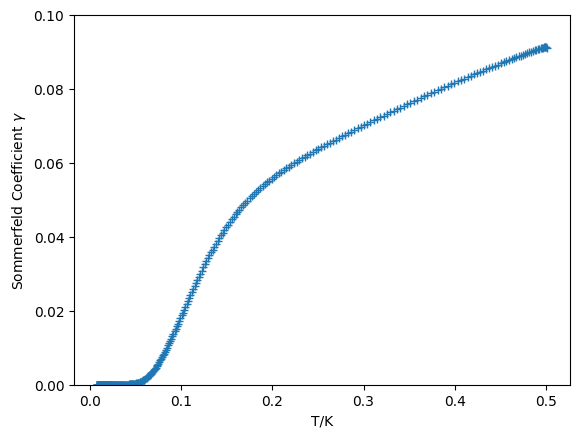

In [18]:
F_arr = F_two_band(np.array(out[0]), out[1][:,0], out[1][:,1])
C_arr = heat_capacity_F(F_arr,np.array(out[0]))
plt.plot(out[0], F_arr)
plt.show()

plt.plot(out[0],C_arr/ out[0],'+')
plt.ylim(0,0.1) # 
plt.xlabel('T/K')
plt.ylabel('Sommerfeld Coefficient $\gamma$')
plt.show()

In [17]:
# see Fig23 from bang2017, it should be slightly different. but exponential suppresion at low T is correct. See if you can recover the normal SH coefficient for T > Tc

## III. Fast Matsubara Summation

In [12]:
import matsubara as matsubara
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson, trapezoid, quad
from gapeqn_library import pade, padecoeffs, padeeval

In [13]:
def partialSum(arr):
    # returns partial sums Sn of a sequence an
    summed = np.zeros(np.size(arr))
    for i in np.arange(len(arr)):
        summed[i] = np.sum(arr[:i+1])
    return summed

def simpsonSum(an, maxN):
    # sum over the first maxN/2 elements in an, and then do a trapezoidal sum with maxN/2 sample points
    division_index = int(maxN/2)
    first_half_sum = np.sum(an[:division_index])
    x_sample = np.linspace(division_index, np.size(an)-1,division_index, dtype = int)
    second_half_sum = simpson(an[x_sample],x= x_sample)
    return first_half_sum + second_half_sum

def trapezoidSum(an, maxN):
    # sum over the first maxN/2 elements in an, and then do a trapezoidal sum with maxN/2 sample points
    division_index = int(maxN/2)
    first_half_sum = np.sum(an[:division_index])
    x_sample = np.linspace(division_index, np.size(an)-1,division_index, dtype = int)
    second_half_sum = trapezoid(an[x_sample],x= x_sample)
    return first_half_sum + second_half_sum

def wynnepsilon(sn):
    """Perform Wynn Epsilon Convergence Algorithm to compute k-th Shank-transformed accelerated series summation. This works due to the asymptotic power-law behaviour of the summand. 
    
    Input
    sn: 1D numpy array of a partial sum to be transformed with dimension N

    Output
    scalar: N-th Shank-transformed partial sum
    """
    n = np.size(sn) 
    r = np.floor((n-1)/2)
    
    e = np.zeros(shape=(n + 1, n + 1), dtype = np.float64)

    for i in range(1, n + 1):
        e[i, 1] = sn[i - 1]

    for i in range(3, n + 2):
        for j in range(3, i + 1):
            e[i - 1, j - 1] = e[i - 2, j - 3] + 1 / (e[i - 1, j - 2] - e[i - 2, j - 2])

    er = e[:, 1:n + 1:2]
    return er

def padeeval_real_wrapper(z_vec,z_arr,a):
    # a simple wrapper of padeeval when all arguments are konwn to be real. returns a real value 
    return np.real(padeeval(np.real(z_vec),np.real(z_arr),np.real(a)))

def pade_quad_Sum(an,num_sum, num_Pade):
    # sum over the first num_sum Matsubara frequency, then evenly sample num_Pade points from num_sum to the end of array to do a Pade interpolation. Approximate the latter sum with a quadrature integral
    sum_first_part = np.sum(an[:num_sum]) # Matsubara sum
    x_sampled = np.logspace(np.log10(num_sum),np.log10(np.size(an) - 1), num_Pade, dtype = int)
    pade_coef = padecoeffs(x_sampled, an[x_sampled])
    sum_second_part = quad(padeeval_real_wrapper,num_sum,np.size(an),args = (x_sampled, pade_coef))[0] # quad integral
    return sum_first_part + sum_second_part

In [14]:
# load test data: Matsubara sum in the SC gap equation
epsilon = 1 
data = np.load(r'data_0820_variable_maxit\T0.02000_Gamma0.160_Tildes_total.npy')
omega_tilde, Delta_h_tilde = data[int(np.shape(data)[0] / 2):,0], data[int(np.shape(data)[0] / 2):,1]

an = 1/(omega_tilde**2 + Delta_h_tilde**2 + epsilon**2) 
sn = partialSum(an)
rel_err_direct = np.abs(sn[-1] - sn) / sn[-1]

In [15]:
# Shank transformation 
n_list = [1,3,10,30,100,300,500,800,1000,2000,3000,5000]
err_list = []
for i in range(np.size(n_list)):
    n = n_list[i]
    shank_approximate = wynnepsilon(sn[:n])[-1,-1]
    rel_err = np.abs(shank_approximate - sn[-1]) / sn[-1]
    err_list.append(rel_err)
err_list = np.array(err_list) 
n_list = np.array(n_list)

# Simpson and Trapozoidal Sum
simpson_err_list = [] 
trapezoid_err_list = []
trapezoid_n_arr = np.linspace(2,np.size(an),100, dtype = int)
for n in trapezoid_n_arr:
    res_simpson = simpsonSum(an,n)
    simpson_err_list.append( np.abs(res_simpson - sn[-1]) / sn[-1])

    res_trapezoid = trapezoidSum(an,n)
    trapezoid_err_list.append(np.abs(res_trapezoid - sn[-1]) / sn[-1])
simpson_err_list = np.array(simpson_err_list)
trapezoid_err_list = np.array(trapezoid_err_list)

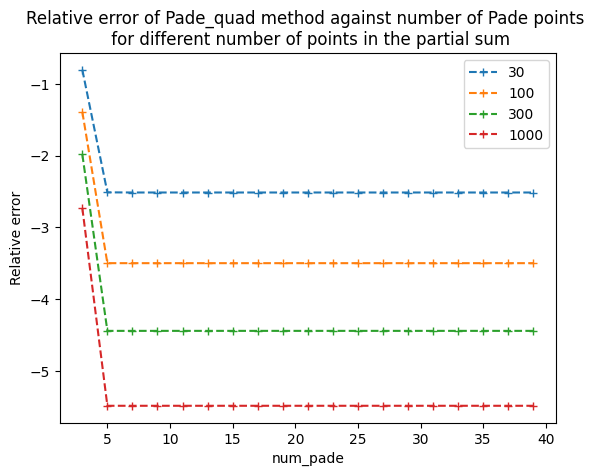

In [16]:
# Pade Interpolation after some point + Quadrature Integration
num_sum_arr = np.array([30, 100,300,1000])
num_pade_arr = np.arange(3,40,2)
pade_err_arr = np.zeros((np.size(num_sum_arr), np.size(num_pade_arr)))
for i in range(np.size(num_sum_arr)):
    for j in range(np.size(num_pade_arr)):
        num_pade = num_pade_arr[j]
        num_sum = num_sum_arr[i]
        res_pade_quad = pade_quad_Sum(an,num_sum,num_pade)
        pade_err_arr[i,j] = np.abs(res_pade_quad - sn[-1]) / sn[-1]

for i in range(np.size(num_sum_arr)):
    num_evaluated = num_pade_arr + num_sum_arr[i]# total number of points evaluted
    plt.plot(num_pade_arr, np.log10(pade_err_arr[i,:]),'+--',label = str(num_sum_arr[i]))
plt.legend(loc = 'best')
plt.ylabel('Relative error')
plt.xlabel('num_pade')
plt.title('Relative error of Pade_quad method against number of Pade points \n for different number of points in the partial sum')
plt.show()

In [17]:
num_sum_arr = np.logspace(0.5,np.log10(np.size(an)-1),dtype = int)
pade_err_arr = np.zeros(np.size(num_sum_arr))
num_pade = 7 # Pade interpolation from 7 points, determined to be sufficient from the previous plot
for i in range(np.size(num_sum_arr)):
    res_pade = pade_quad_Sum(an,num_sum_arr[i],num_pade)
    pade_err_arr[i] = np.abs(res_pade - sn[-1]) / sn[-1]

c:\Users\tcsxx\OneDrive - University of Cambridge\2024 QM Summer Project\Superconductivity_numerics\Python Scripts\two-band-superconductor\gapeqn_library.py:314: RuntimeWarning: invalid value encountered in scalar divide
  g[p,i]=(g[p-1,p-1]-g[p-1,i])/((z[i]-z[p-1])*g[p-1,i]);
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_19336\1501447824.py:57: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sum_second_part = quad(padeeval_real_wrapper,num_sum,np.size(an),args = (x_sampled, pade_coef))[0] # quad integral


C:\Users\tcsxx\AppData\Local\Temp\ipykernel_19336\2632253025.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(rel_err_direct), label = 'partial sum')
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_19336\2632253025.py:18: RuntimeWarning: divide by zero encountered in log10
  inset_axes.plot(np.log10(rel_err_direct), label = 'partial sum')


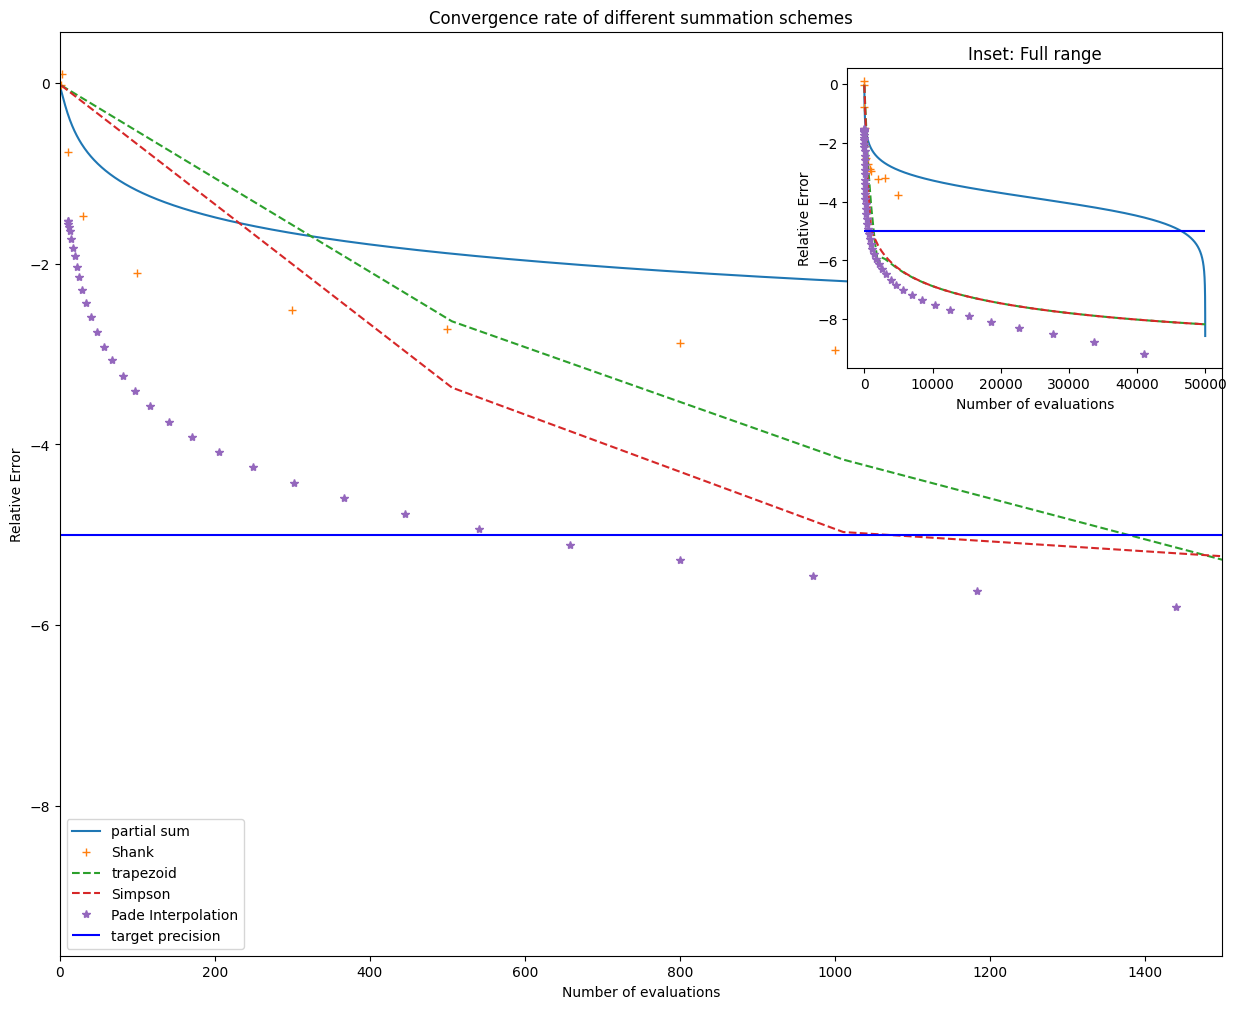

In [18]:
# Main plot: with xlim
plt.figure(figsize=(15, 12))  # Larger figure size
plt.plot(np.log10(rel_err_direct), label = 'partial sum')
# plt.plot(np.log10(an/sn[-1]), label = 'an/S (all interpolation)')
plt.plot(n_list, np.log10(err_list),'+' ,label = 'Shank')
plt.plot(trapezoid_n_arr, np.log10(trapezoid_err_list), '--',label = 'trapezoid')
plt.plot(trapezoid_n_arr,np.log10(simpson_err_list),'--',label = 'Simpson')
plt.plot(num_pade + num_sum_arr, np.log10(pade_err_arr), '*', label = 'Pade Interpolation')
plt.hlines(-5,0,np.size(an),'blue',label = 'target precision')
plt.xlabel('Number of evaluations')
plt.ylabel('Relative Error')
plt.title('Convergence rate of different summation schemes')
plt.xlim(0,1500)  # Apply xlim to the main plot
plt.legend(loc = 'lower left')

# Inset plot: without xlim
inset_axes = plt.axes([0.65, 0.60, 0.25, 0.25])  # Position of the inset [left, bottom, width, height]
inset_axes.plot(np.log10(rel_err_direct), label = 'partial sum')
# inset_axes.plot(np.log10(an/sn[-1]), label = 'an/S (all interpolation)')
inset_axes.plot(n_list, np.log10(err_list),'+' ,label = 'Shank')
inset_axes.plot(trapezoid_n_arr, np.log10(trapezoid_err_list), '--',label = 'trapezoid')
inset_axes.plot(trapezoid_n_arr,np.log10(simpson_err_list),'--',label = 'Simpson')
inset_axes.plot(num_pade + num_sum_arr, np.log10(pade_err_arr), '*', label = 'Pade Interpolation')
inset_axes.hlines(-5,0,np.size(an),'blue',label = 'target precision')
inset_axes.set_xlabel('Number of evaluations')
inset_axes.set_ylabel('Relative Error')
inset_axes.set_title('Inset: Full range')  # Title for the inset


plt.show()

### Pade Decomposition (Ozaki2007, Han2017)
$$\sum_{i\omega_n}^{\infty}g(i \omega_n) = \sum_{j = -N_P}^{N_P} \eta_j g(i \xi_j)$$
where weights $\eta_j$ and $\xi_j$ are given by the Pade spectral decomposition of the Fermi function.
needs to solve the self-consistent equations at $\xi_j$

In [19]:
from cfr import CFR # module to compute the Pade Decomposition of FD function

In [20]:
def Lorentzian(z,s):
    return 1 / (z**2 + s**2)
def partialSum_Lorentzian(T, n_arr,s):
    partial_sum_arr = np.zeros(n_arr.shape)
    for i in range(len(n_arr)):
        n = n_arr[i]
        omega_arr = (2*np.arange(n)+1) * np.pi * T
        partial_sum =  2 * np.sum(Lorentzian(omega_arr,s)) # double as we sum from -infty to infty
        partial_sum_arr[i] = partial_sum
    return partial_sum_arr  

def res_analytic(T,s):
    return 1/(2*s*T) * np.tanh(s/(2*T))

def pade_decomposition_lorentzian(T,s,num_pade):
    # input: number of positive pade points to be evaluated ; T,s param for Lorentzian
    cfr_cutoff = 2 * num_pade
    poles, residues = CFR(cfr_cutoff).get_poles_and_residues()
    poles = 1 / poles
    mask = poles >= 0
    filtered_poles = poles[mask]    # keep positive poles only due to symmetry
    filtered_residues = residues[mask]

    result = 2 * np.sum(filtered_residues * Lorentzian(filtered_poles * T, s))
    return np.real(result)

In [75]:
# define the Lorentzian parameters
s = 10
T = 1

N_cutoff_max = 10000
n = np.arange(N_cutoff_max)

# direct Partial sum
partial_sum_res = partialSum_Lorentzian(T,n,s)
partial_sum_err = np.abs(partial_sum_res - res_analytic(T,s) ) / res_analytic(T,s)

# the Pade Interpolation method
omega_arr = (2*n+1) * np.pi * T
an = Lorentzian(omega_arr,s)

num_sum_arr = np.logspace(0.5,np.log10(N_cutoff_max-1)-1,dtype = int)
pade_err_arr = np.zeros(np.size(num_sum_arr))
num_pade = 7 # Pade interpolation from 7 points, determined to be sufficient from the previous plot

for i in range(np.size(num_sum_arr)):
    res_pade = 2 * pade_quad_Sum(an,num_sum_arr[i],num_pade) # Pade interpolation
    pade_err_arr[i] = np.abs(res_pade -res_analytic(T,s)) / res_analytic(T,s)

# Pade decomposition
pade_cutoff_arr = np.arange(1,50,1)
pade_decomp_err_arr = np.zeros(pade_cutoff_arr.shape)
for i in range(len(pade_cutoff_arr)):
    pade_cutoff = pade_cutoff_arr[i]
    res_decom = pade_decomposition_lorentzian(T,s,pade_cutoff)
    pade_decomp_err_arr[i] = np.abs(res_decom - res_analytic(T,s)) / res_analytic(T,s)

C:\Users\tcsxx\AppData\Local\Temp\ipykernel_19336\1501447824.py:57: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sum_second_part = quad(padeeval_real_wrapper,num_sum,np.size(an),args = (x_sampled, pade_coef))[0] # quad integral


[]

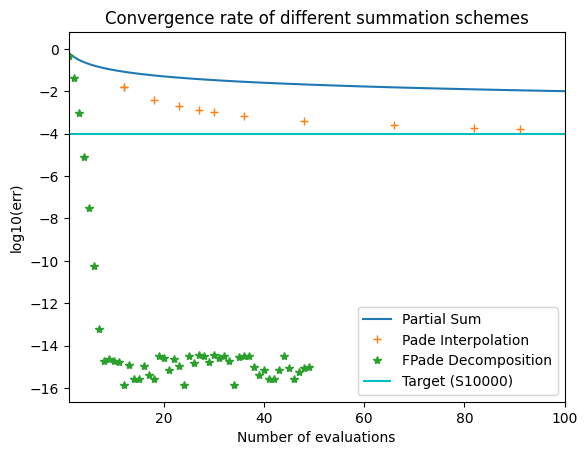

In [76]:
plt.plot(n,np.log10(partial_sum_err), label = 'Partial Sum')
plt.plot(num_pade + num_sum_arr, np.log10(pade_err_arr), '+',label = 'Pade Interpolation')
plt.plot(pade_cutoff_arr, np.log10(pade_decomp_err_arr),'*',label = 'FPade Decomposition')
plt.hlines(-4,np.amin(n),np.amax(n),'c',label = 'Target (S10000)')
# plt.hlines(res_analytic(T,s),np.amin(n),np.amax(n))
plt.xlim(1,100)
plt.title('Convergence rate of different summation schemes')
plt.xlabel('Number of evaluations')
plt.ylabel('log10(err)')
plt.legend(loc = 'best')
plt.plot()

In [89]:
max_energy_list = []
for n in range(1,100):
    a,b = CFR(2*n).get_poles_and_residues()
    max_energy_list.append(np.amax(1/a))
max_energy_list = np.array(max_energy_list)

In [99]:
def generate_FPade_poles_and_weights(FPade_maxN_list):
    """
    Generates poles and weights for the Pade decomposition of the Fermi-Dirac distribution's continued fraction representation.

    ### Description:
    The function converts a Matsubara sum over a function `f(i omega_n)` into a sum over positive poles using a Pade decomposition approach:
    
    \[
    \sum_{-\infty}^{\infty} f(i \omega_n) \approx \sum_{j=1}^{N} b_j \cdot f\left(\frac{a_j}{k_B T}\right)
    \]
    
    where:
    - \( \omega_n = (2n+1)\pi k_B T \) are Matsubara frequencies.
    - \( a_j \) are the poles, and \( b_j \) are the corresponding weights.
    
    The function returns a dictionary containing these poles and weights for each value of `N` in the input list.

    ### Parameters:
    - `FPade_maxN_list`: `list[int]`
        - A list of integers specifying the maximum number of poles (denoted by `N`) for which poles and weights should be generated.
        - Example: `[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]`.

    ### Returns:
    - `FPade_params_dict`: `dict[str, np.ndarray]`
        - A dictionary where each key is a string representation of an integer `N` (from `FPade_maxN_list`), and the corresponding value is a `2xN` numpy array:
            - The first row contains the `N` positive poles.
            - The second row contains the corresponding `N` weights.
        - Example:
          ```python
          {
              "5": np.array([
                      [pole1, pole2, pole3, pole4, pole5],  # First row: Poles
                      [weight1, weight2, weight3, weight4, weight5]  # Second row: Weights
                  ]),
              ...
          }
          ```

    ### Procedure:
    1. For each `N` in `FPade_maxN_list`, calculate the poles and residues for the continued fraction representation (CFR) with a cutoff at `2*N`.
    2. Filter the calculated poles to keep only the positive values.
    3. Take the reciprocal of the positive poles.
    4. Double the corresponding residues to account for symmetry (since only positive poles are kept).
    5. Store the poles and weights in the dictionary as a `2xN` numpy array.
    6. Save the dictionary as a `.npy` file.
    
    ### Warnings:
    - The poles returned are not sorted, so all of them must be included when using the result.
    
    ### Example Usage:
    ```python
    FPade_maxN_list = [5, 10, 15, 20]
    FPade_params = generate_FPade_poles_and_weights(FPade_maxN_list)
    ```
    """
    
    FPade_params_dict = {}
    
    for N in FPade_maxN_list:
        # Set cutoff for continued fraction representation (CFR)
        cfr_cutoff = 2 * N
        
        # Generate poles and residues using CFR (assuming CFR is a predefined function)
        poles, residues = CFR(cfr_cutoff).get_poles_and_residues()
        
        # Filter positive poles and corresponding residues
        mask = poles >= 0
        filtered_poles = 1 / poles[mask]    # Take reciprocal of positive poles
        filtered_residues = 2 * residues[mask] # Double the weights
        
        # Store results in the dictionary
        result = np.array([filtered_poles, filtered_residues])
        FPade_params_dict[str(N)] = result
    
    # Save the dictionary to a file
    np.save('FPade_Poles_and_Weights.npy', FPade_params_dict)
    
    return FPade_params_dict


<>:2: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\['
C:\Users\tcsxx\AppData\Local\Temp\ipykernel_19336\3131782868.py:2: SyntaxWarning: invalid escape sequence '\['
  """


In [101]:
FPade_maxN_list = np.array([5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120,150,200,500,1000])
generate_FPade_poles_and_weights(FPade_maxN_list)

{'5': array([[ 3.14159265+0.j,  9.42478813+0.j, 15.76218003+0.j,
         24.87650795+0.j, 70.52670981+0.j],
        [ 2.        +0.j,  2.00004041+0.j,  2.09678606+0.j,
          4.64356451+0.j, 44.25960902+0.j]]),
 '10': array([[  3.14159265+0.j,   9.42477796+0.j,  15.70796327+0.j,
          21.99114868+0.j,  28.27469813+0.j,  34.62641556+0.j,
          42.30314058+0.j, 267.89788248+0.j,  56.2524856 +0.j,
          90.71566977+0.j],
        [  2.        +0.j,   2.        +0.j,   2.        +0.j,
           2.00000034+0.j,   2.00076143+0.j,   2.08794211+0.j,
           3.06106325+0.j, 169.88822318+0.j,   6.40363441+0.j,
          18.55837529+0.j]]),
 '15': array([[  3.14159265+0.j,   9.42477796+0.j,  15.70796327+0.j,
          21.99114858+0.j,  28.27433388+0.j,  34.55751919+0.j,
          40.8407066 +0.j,  47.12476488+0.j, 592.5773133 +0.j,
          53.47022443+0.j,  60.65035646+0.j,  71.07793772+0.j,
         198.93214871+0.j,  88.49072906+0.j, 121.10533158+0.j],
        [  2.        

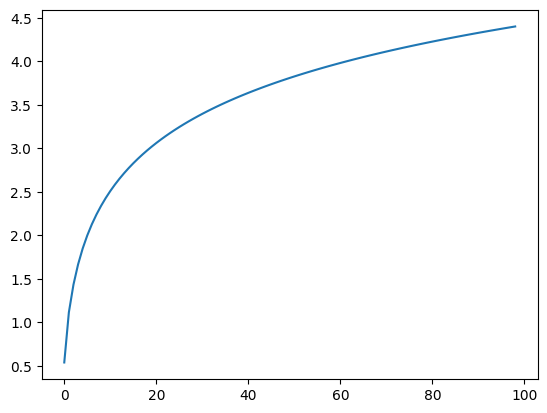

In [91]:
plt.plot(np.log10(np.real(max_energy_list)))
plt.show()